# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sportsipy.nba.teams import Teams
from sportsipy.nba.roster import Roster, Player
from basketball_reference_scraper.teams import get_team_misc

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

import pickle

# set options
sns.set_context('paper')
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

## Define a few variables
> Here you can define the team abbreviation, the team name, and the two seasons (past and current) that you want to observe. Additionally, you can define team colors for usage in any graphics generated by this notebook. Please see this [link](https://teamcolorcodes.com/nba-team-color-codes/) for Hex codes of team colors.

In [2]:
team_abbreviation = 'CHO'
team_name = 'Charlotte Hornets'
past_season = 2020
current_season = 2021
team_colors = ['#A1A1A4', '#00788C']

# Question 1:
> Using the four-factor model discussed in Chapter 28 of Mathletics, determine where we ranked in the NBA last season and how we currently stack up so far this season. Briefly describe where we are deficient and where we excel.

> I'll be looking at the Charlotte Hornets.

> **Uncomment if you want to run the code below**

In [3]:
# a function for grabbing all NBA teams and returning a concatenated dataframe for a specified year
def get_teams(year):
    # initialize an empty dataframe
    df = pd.DataFrame()
    
    # grab the Teams
    teams = Teams(year = year)
    
    # loop through all teams
    for team in teams:
        team_df = team.dataframe
        team_df['Wins'] = get_team_misc(team.abbreviation, year)['W']
        df = pd.concat([df, team_df])
    df['season'] = np.repeat(year, df.shape[0])
    return df

# # grab all nba teams by season
# nba_teams_past_season = get_teams(past_season)
# nba_teams_current_season = get_teams(current_season)

# # concatenate both results together
# two_seasons = pd.concat([nba_teams_past_season, nba_teams_current_season])

# # export to a csv file
# two_seasons.to_csv('nba_teams_2020_2021.csv', index = False)
teams = pd.read_csv('data/nba_teams_2020_2021.csv')

In [4]:
# a function for calculating the 4 factors (without using Lambda functions)
def get_4_factors(df):
    
    # get number of possessions for later use
    two_pa = df['two_point_field_goal_attempts'].to_numpy()
    three_pa = df['three_point_field_goal_attempts'].to_numpy()
    fta = df['free_throw_attempts'].to_numpy()
    oreb = df['offensive_rebounds'].to_numpy()
    tov = df['turnovers'].to_numpy()
    possessions = (two_pa + three_pa) + 0.44 * fta - oreb + tov
    
    # effective field goal percentage
    two_fg = df['two_point_field_goals'].to_numpy()
    three_fg = df['three_point_field_goals'].to_numpy()
    fga = df['field_goal_attempts'].to_numpy()
    efg = (two_fg + 1.5 * three_fg) / fga
    
    # turnovers per possession
    tpp = tov / possessions
    
    # rebound percentage
    oreb = df['offensive_rebounds'].to_numpy()
    dreb_o = df['opp_defensive_rebounds'].to_numpy()
    orp = oreb / (oreb + dreb_o)
    
    # free throw rate
    ftm = df['free_throws'].to_numpy()
    ftr = ftm / (two_pa + three_pa)
    
    # opponents possessions
    opp_two_pa = df['opp_two_point_field_goal_attempts'].to_numpy()
    opp_three_pa = df['opp_three_point_field_goal_attempts'].to_numpy()
    opp_fta = df['opp_free_throw_attempts'].to_numpy()
    opp_oreb = df['opp_offensive_rebounds'].to_numpy()
    opp_tov = df['opp_turnovers'].to_numpy()
    opp_possessions = (opp_two_pa + opp_three_pa) + 0.44 * opp_fta - opp_oreb + opp_tov
    
    # opponents effective field goal percentage
    opp_two_fg = df['opp_two_point_field_goals'].to_numpy()
    opp_three_fg = df['opp_three_point_field_goals'].to_numpy()
    opp_fga = df['opp_field_goal_attempts'].to_numpy()
    oefg = (opp_two_fg + 1.5 * opp_three_fg) / opp_fga

    # defensive turnovers caused per possession
    dtpp = opp_tov / opp_possessions

    # defensive rebounding percentage
    dreb = df['defensive_rebounds'].to_numpy()
    opp_oreb = df['opp_offensive_rebounds'].to_numpy()
    drp = dreb / (opp_oreb + dreb)
    
    # opponents free throw rate
    opp_ftm = df['opp_free_throws'].to_numpy()
    opp_ftr = opp_ftm / (opp_two_pa + opp_three_pa)
    
    # assign respective columns from results found above
    df['possessions'] = possessions
    df['eFG%'] = efg
    df['TPP'] = tpp
    df['OR%'] = orp
    df['FTR'] = ftr
    df['opp_possessions'] = opp_possessions
    df['OeFG%'] = oefg
    df['DTPP'] = dtpp
    df['DR%'] = drp
    df['OFTR'] = opp_ftr
    
    return df

In [5]:
# a function to create a barplot comparing 2 seasons
def create_barplot(df, title, hue):
    g = sns.catplot(x = 'Four Factors (Offense & Defense)', y = 'value', 
                    hue = hue, data = df, kind = 'bar', palette = team_colors)
    plt.title(title)
    show_values_on_bars(g.ax)
    plt.ylim(0, 1)
    plt.savefig(f'images/{title}.png', bbox_inches = 'tight')
    plt.show()

# a helper function for the barplot to display values
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.02
            value = '{:.3f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", rotation = 90) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [6]:
def summary(df):
    four_factors = ['eFG%', 'TPP', 'OR%', 'FTR', 'OeFG%', 'DTPP', 'DR%', 'OFTR']

    # filter for desired team
    team_df = df[df['abbreviation'] == team_abbreviation]
    
    # last season compared to current season
    team_melt = team_df.melt(id_vars = ['abbreviation', 'season'], value_vars = four_factors,
                            var_name = 'Four Factors (Offense & Defense)')
    title = f'{team_name}\'s {past_season} season versus the {current_season} season'
    create_barplot(team_melt, title, 'season')
    
    # comparing past season with past season's averages
    all_teams_s1 = df[df['season'] == past_season]
    team_stats_s1 = team_df[team_df['season'] == past_season][four_factors]
    team_stats_s1['Team'] = [f'{team_name} {past_season}']
    league_avg = all_teams_s1[four_factors].mean()
    league_avg = pd.DataFrame(dict(zip(league_avg.index, league_avg.values)), index = [100])
    league_avg['Team'] = f'League average {past_season}'
    
    summary_s1 = pd.concat([league_avg, team_stats_s1]).reset_index().drop('index', axis = 1)
    summary_s1_melt = summary_s1.melt(id_vars = ['Team'], var_name = 'Four Factors (Offense & Defense)')
    title = f'{team_name}\'s {past_season} season with the League\'s {past_season} averages'
    create_barplot(summary_s1_melt, title, 'Team')
    
    # comparing current season with current season's averages
    all_teams_s2 = df[df['season'] == current_season]
    team_stats_s2 = team_df[team_df['season'] == current_season][four_factors]
    team_stats_s2['Team'] = [f'{team_name} {current_season}']
    league_avg = all_teams_s2[four_factors].mean()
    league_avg = pd.DataFrame(dict(zip(league_avg.index, league_avg.values)), index = [100])
    league_avg['Team'] = f'League average {current_season}'
    
    summary_s2 = pd.concat([league_avg, team_stats_s2]).reset_index().drop('index', axis = 1)
    summary_s2_melt = summary_s2.melt(id_vars = ['Team'], var_name = 'Four Factors (Offense & Defense)')
    title = f'{team_name}\'s {current_season} season with the League\'s {current_season} averages'
    create_barplot(summary_s2_melt, title, 'Team')

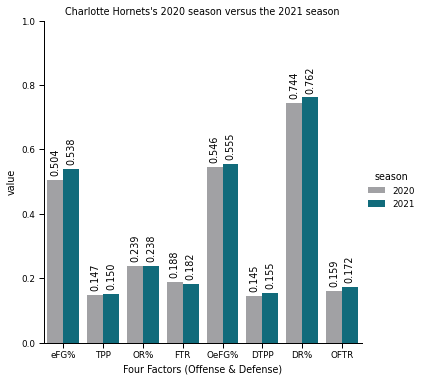

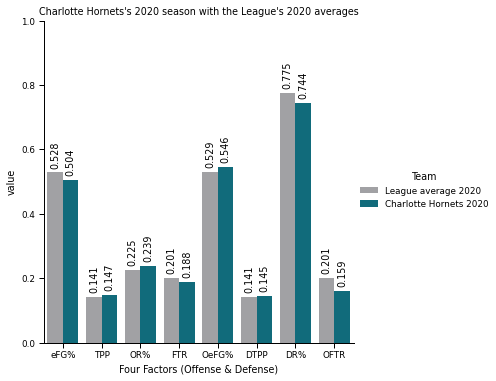

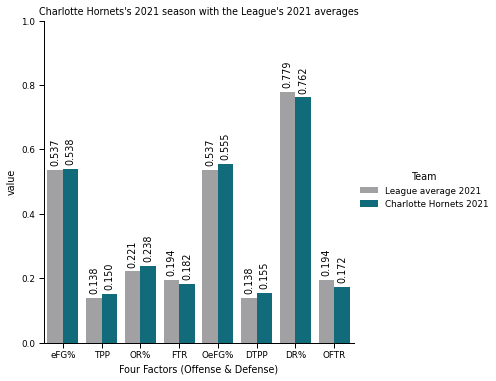

In [7]:
teams = get_4_factors(teams)
summary(teams)

# Question 2:
> Looking at page 193 in Mathletics, conduct a similar analysis that determines the relative importance of each of the four factors. Based on your findings, how many games should we have won last year? Make sure to use a training and a test set to evaluate your predictions.

## Pull data for years 2003 thru 2021
> Uncomment if you want to re-run

In [8]:
# years = np.arange(2003, 2022)
# teams_2003_2021 = pd.DataFrame()
# for year in years:
#     print(f'Getting teams from the year {year}')
#     df = get_teams(year)
#     teams_2003_2021 = pd.concat([teams_2003_2021, df])
# four_factors = ['eFG%', 'TPP', 'OR%', 'FTR', 'OeFG%', 'DTPP', 'DR%', 'OFTR']
# teams_2003_2021 = get_4_factors(teams_2003_2021)
# teams_2003_2021.to_csv('data/NBA_Teams_2003_to_2021.csv', index = False)
all_teams = pd.read_csv('data/NBA_Teams_2003_to_2021.csv')

## Data Preprocessing

In [9]:
# function to calculate regression factors found in Mathletics (by taking the difference between offensive
# and defensive four factors per team)
def calculate_regression_factors(df):
    df['EFG-OEFG'] = df.apply(lambda x: x['eFG%'] - x['OeFG%'], axis = 1)
    df['TPP-DTPP'] = df.apply(lambda x: x['TPP'] - x['DTPP'], axis = 1)
    df['ORP-DRP'] = df.apply(lambda x: x['OR%'] - x['DR%'], axis = 1)
    df['FTR-OFTR'] = df.apply(lambda x: x['FTR'] - x['OFTR'], axis = 1)
    
    return df

ff_plus_wins = ['Wins', 'eFG%', 'TPP', 'OR%', 'FTR', 'OeFG%', 'DTPP', 'DR%', 'OFTR', 'season']
all_teams = all_teams[ff_plus_wins]
all_teams = calculate_regression_factors(all_teams)

> Split data into train (75%) and test (25%) sets.

In [10]:
# Filter by 2011 thru 2018 (inclusive) seasons
years = np.arange(2011, 2020, 1) # likely the best and fairest range

# Filter the dataframe by seasons defined above
all_teams = all_teams[all_teams['season'].isin(years)]

X = all_teams.drop(ff_plus_wins, axis = 1)
y = all_teams['Wins']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 469)

## Modeling

Feature: 0, Score: 356.90530
Feature: 1, Score: -240.40027
Feature: 2, Score: -0.48479
Feature: 3, Score: 96.87580


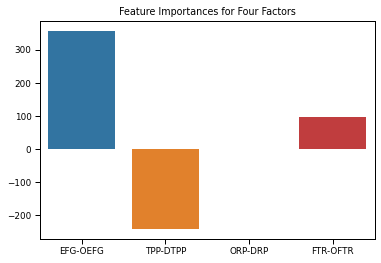

In [11]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

importance = model.coef_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

sns.barplot(x = X.columns.tolist(), y = importance)
plt.title('Feature Importances for Four Factors')
plt.savefig('images/Feature Importances for Four Factors.png')
plt.show()

### Model Evaluation

In [12]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    print('explained_variance: ', np.round(explained_variance,4))
    print('mean_squared_log_error: ', np.round(mean_squared_log_error,4))
    print('r2: ', np.round(r2,4))
    print('MAE: ', np.round(mean_absolute_error,4))
    print('MSE: ', np.round(mse,4))
    print('RMSE: ', np.round(np.sqrt(mse),4))
regression_results(y_test, y_pred)

explained_variance:  0.9133
mean_squared_log_error:  0.0084
r2:  0.9117
MAE:  2.9528
MSE:  14.7027
RMSE:  3.8344


In [13]:
def predict_wins_past_season(df):
    regression_features = ['EFG-OEFG', 'TPP-DTPP', 'ORP-DRP', 'FTR-OFTR']
    # team and their past season
    team_past_season = df[(df['abbreviation'] == team_abbreviation) & (df['season'] == past_season)]
    
    # How many games should we have won last year?
    team_past_season = calculate_regression_factors(team_past_season)
    team_past_season_input = team_past_season[regression_features] 
    pred_wins = int(model.predict(team_past_season_input)[0])
    
    games_played = int(team_past_season['games_played'].values[0])
    adjusted_wins = int(games_played * (pred_wins / 72))
    total_wins = int(team_past_season['Wins'].values[0])
    wins_difference = total_wins - adjusted_wins
    performance = 'above expectations' if wins_difference > 0 else 'at expectations' if wins_difference == 0 else 'below expectations'
    
    blurb = f'''
The {team_name} won {total_wins} games in the {past_season} season.
Based on their performance with respect to the Offensive and Defensive Four Factors,
we predict their total wins to be {pred_wins} wins in a full season of 72 games.
Because of the circumstances of COVID-19, they did not play a full 72-game season.
In the {past_season} season, the {team_name} have played {games_played} games.
Their expected wins as a ratio of {pred_wins}/72 games is {adjusted_wins}.
The {team_name} are performing {performance} for the {past_season} season.
'''
    print(blurb)

> COVID-19 cut the season short, so this isn't really a fair comparison because the Hornets only had a certain number of games played. Let's go with a proportion of the wins we can expect based on their current track record.

In [14]:
predict_wins_past_season(teams)


The Charlotte Hornets won 23 games in the 2020 season.
Based on their performance with respect to the Offensive and Defensive Four Factors,
we predict their total wins to be 27 wins in a full season of 72 games.
Because of the circumstances of COVID-19, they did not play a full 72-game season.
In the 2020 season, the Charlotte Hornets have played 65 games.
Their expected wins as a ratio of 27/72 games is 24.
The Charlotte Hornets are performing below expectations for the 2020 season.



# Question 3:
> Using historical data, determine a new classification framework for identifying player types. Provide a description of each player type based on the metrics that you select.

## Data Preparation
> I grab the data by getting each player on each roster during the 2021 season. This takes a while to run so please uncomment if you want the latest dataset from sports-reference.com .

> Additionally, I'll have to drop some columns because not everything is needed for KMeans clustering. 

In [15]:
# a function to get players on each roster
def get_players_per_roster_year(year):
    teams = Teams(year = year)
    abbreviations = []
    player_names = []
    df = pd.DataFrame()
    
    # get all team abbreviations
    for team in teams:
        abbreviations.append(team.abbreviation)
        
    # get roster for each team
    for team in abbreviations:
        print(f'Grabbing players on roster with team abbrevation {team}')
        team_roster = Roster(team)
        for player in team_roster.players:
            df = pd.concat([df, player.dataframe])
    
    # filter by player's entire career
    print('Filtering by Career')
    df = df.filter(like = 'Career', axis = 0)
    
    # get player names and concatenate to dataframe
    print('Grabbing player names from player ids')
    df = get_player_names(df)
    
    return df

# a function to get player names using player id
def get_player_names(df):
    player_ids = df['player_id'].tolist()
    player_names = []
    for pid in player_ids:
        player_names.append(Player(pid).name)
    player_names_s = pd.Series(player_names)
    df = pd.concat([df.reset_index(), player_names_s], axis = 1).rename(columns={0: 'player_name'})
    return df

# a function to calculate per minute statistics
def get_per_game_stats(df):
    # points per game
    df['PPG'] = np.round(df['points'].divide(df['games_played']), 1)
    
    # assists per game
    df['APG'] = np.round(df['assists'].divide(df['games_played']), 1)
    
    # blocks per game
    df['BPG'] = np.round(df['blocks'].divide(df['games_played']), 1)
    
    # rebounds per game
    df['RPG'] = np.round(df['total_rebounds'].divide(df['games_played']), 1)
    
    # steals per game
    df['SPG'] = np.round(df['steals'].divide(df['games_played']), 1)
    
    # turnovers per game
    df['TPG'] = np.round(df['turnovers'].divide(df['games_played']), 1)
    
    return df

In [16]:
# # uncomment below if you want to run
# nba_players = get_players_per_roster_year(2021)
# nba_players.to_csv('data/nba_players_2021.csv', index = False)
nba_players = pd.read_csv('data/nba_players_2021.csv')

> Calculate per game and per minute statistics.

In [17]:
nba_players = get_per_game_stats(nba_players)

> Drop columns and filter by players with minutes greater than or equal to 500 played in their entire career.

In [18]:
drop_list = ['and_ones', 'blocking_fouls', 'center_percentage', 
             'dunks', 'nationality', 'games_played', 'games_started',
             'half_court_heaves', 'half_court_heaves_made', 'height',
             'lost_ball_turnovers', 'net_plus_minus', 'offensive_fouls',
             'on_court_plus_minus', 'other_turnovers', 'passing_turnovers',
             'percentage_field_goals_as_dunks', 'percentage_of_three_pointers_from_corner',
             'percentage_shots_three_pointers', 'percentage_shots_two_pointers', 'player_id', 
             'points_generated_by_assists', 'salary', 'shooting_fouls', 'shooting_fouls_drawn',
             'shots_blocked', 'small_forward_percentage', 'take_fouls', 'team_abbreviation',
             'three_point_shot_percentage_from_corner', 'three_pointers_assisted_percentage',
             'two_pointers_assisted_percentage', 'position', 'level_0', 'weight', 'minutes_played',
             'win_shares', 'point_guard_percentage', 'power_forward_percentage', 'shooting_guard_percentage',
             'points', 'games_started', 'two_pointers', 'three_pointers', 'assists', 'total_rebounds', 'blocks',
             'steals', 'turnovers']

# grab per possession stats and add them to drop list
per_poss_stats = nba_players.filter(like='per_poss').columns.tolist()
drop_list.extend(per_poss_stats)

# filter by NBA players that have played greater than 500 minutes in their career
nba_players = nba_players[nba_players['minutes_played'] >= 500]

nba_players.drop(drop_list, axis = 1, inplace = True)
print(nba_players.shape[1])

49


> Exploring null values for players and filling them in with 0 (because those players have not attempted three pointers in their entire career although they meet the minutes requirement)

In [19]:
# print any null columns
for col in nba_players.columns.tolist():
    null_vals = nba_players[col].isna().sum()
    if null_vals != 0:
        print(f'{col} with {null_vals} null values')

# fill in null values with 0
nba_players.fillna(0, inplace = True)

# save player names for later
player_names = nba_players['player_name']

nba_players.drop('player_name', axis = 1, inplace = True)

field_goal_perc_sixteen_foot_plus_two_pointers with 1 null values
three_point_percentage with 2 null values


## Modeling Preparation
> I use Standardization so all variables are treated as equal with a mean of 0 and a variance of 1.

> Additionally, I want to explore dimensional reduction to find the optimal number of PCA components while explaining the majority of the variance.

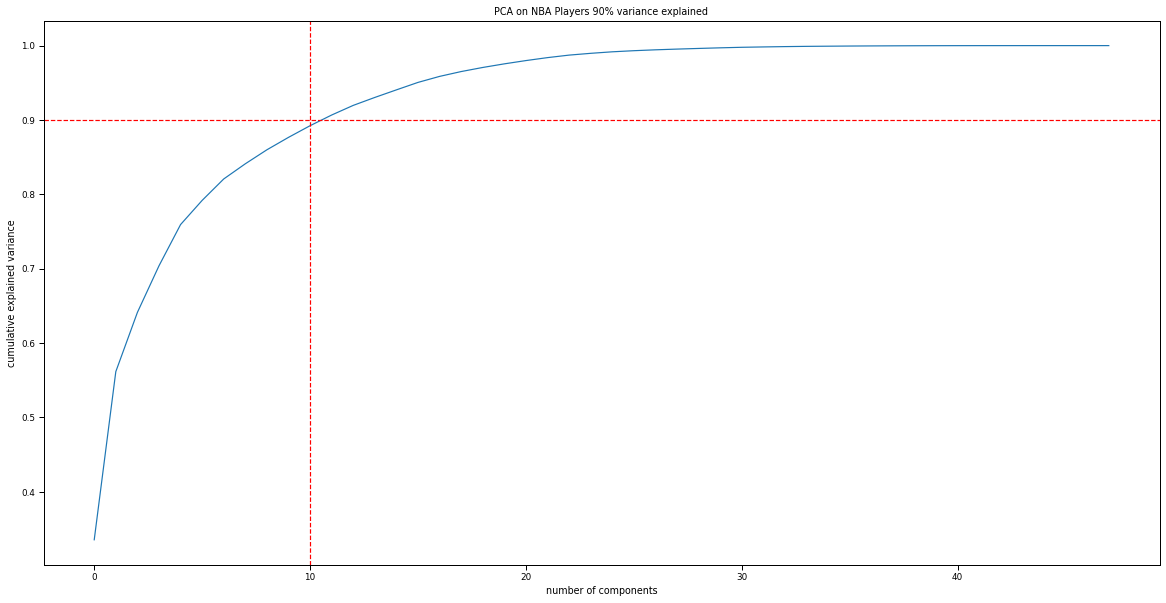

In [20]:
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(nba_players)

plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y = 0.90, color = 'red', linestyle = '--')
plt.axvline(x = 10, color = 'red', linestyle = '--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
title = 'PCA on NBA Players 90% variance explained'
plt.title(title)
plt.savefig(f'images/{title}.png', bbox_inches = 'tight')
plt.show()

> Set PCA to 10 components as it explained almost 90% of the variance found in the dataset.

In [21]:
pca = PCA(n_components = 10)
pipeline = make_pipeline(scaler, pca)
X_scaled = pipeline.fit_transform(nba_players)

> Find the ideal number of clusters by exploring different numbers of clusters and plotting their intertias in an elbow plot. The output should show that the ideal number of clusters is difficult to determine, so I'll safely go with 8-10 clusters.

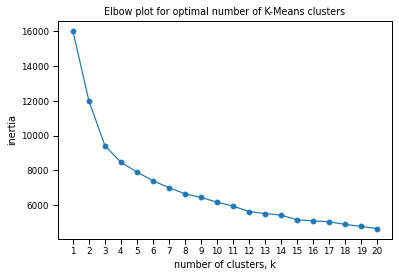

In [22]:
ks = range(1, 21)
inertias = []
for k in ks:
    model = KMeans(n_clusters = k)
    model.fit(X_scaled)
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.title('Elbow plot for optimal number of K-Means clusters')
plt.xticks(ks)
plt.savefig('images/elbow_plot.png')
plt.show()

## Modeling
> I'll model with 10 clusters using a pipeline of standardization -> PCA -> KMeans

In [23]:
model = KMeans(n_clusters = 10, random_state = 42)
pipeline = make_pipeline(scaler, pca, model)
pipeline.fit_transform(nba_players)
labels = pipeline.predict(nba_players)

## Evaluate KMeans Clustering
> I create a dataframe using the original dataset and append the player_names dataframe I placed aside.

In [24]:
# create a dataframe with cluster labels
labels_df = pd.DataFrame({'labels': labels})
df = pd.concat([nba_players.reset_index(), 
           player_names.reset_index(), labels_df], axis = 1)
df.drop('index', axis = 1, inplace = True)

### Observing stats

In [25]:
per_game_stats = ['PPG', 'APG', 'BPG', 'RPG', 'SPG', 'TPG']
df_cl = df.groupby('labels')
np.round(df_cl.mean(), 2)

,assist_percentage,block_percentage,box_plus_minus,defensive_box_plus_minus,defensive_rebound_percentage,defensive_rebounds,defensive_win_shares,effective_field_goal_percentage,field_goal_attempts,field_goal_perc_sixteen_foot_plus_two_pointers,field_goal_perc_ten_to_sixteen_feet,field_goal_perc_three_to_ten_feet,field_goal_perc_zero_to_three_feet,field_goal_percentage,field_goals,free_throw_attempt_rate,free_throw_attempts,free_throw_percentage,free_throws,offensive_box_plus_minus,offensive_rebound_percentage,offensive_rebounds,offensive_win_shares,percentage_sixteen_foot_plus_two_pointers,percentage_ten_to_sixteen_footers,percentage_three_to_ten_footers,percentage_zero_to_three_footers,personal_fouls,player_efficiency_rating,shooting_distance,steal_percentage,three_point_attempt_rate,three_point_attempts,three_point_percentage,total_rebound_percentage,true_shooting_percentage,turnover_percentage,two_point_attempts,two_point_percentage,usage_percentage,value_over_replacement_player,win_shares_per_48_minutes,PPG,APG,BPG,RPG,SPG,TPG
labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,9.47,3.71,0.47,0.48,23.78,2913.77,19.06,0.55,4098.58,0.31,0.35,0.40,0.68,0.55,2248.35,0.41,1634.27,0.64,1032.81,-0.02,11.27,1425.73,21.71,0.07,0.08,0.26,0.56,1408.19,18.14,5.17,1.37,0.03,112.27,0.18,17.52,0.58,14.00,3986.31,0.56,18.47,7.96,0.14,10.48,1.58,1.08,7.92,0.70,1.49
1,15.62,1.23,-2.87,-0.19,12.07,396.77,3.29,0.47,1198.56,0.32,0.35,0.33,0.58,0.40,487.34,0.20,249.23,0.74,182.52,-2.68,2.71,88.35,-0.06,0.08,0.08,0.16,0.27,319.65,10.34,14.40,1.81,0.41,471.01,0.33,7.35,0.50,13.76,727.55,0.45,18.02,-0.30,0.04,7.64,2.25,0.29,2.81,0.77,1.21
2,31.86,1.11,6.07,0.76,15.61,5000.00,43.33,0.52,17365.00,0.42,0.43,0.40,0.65,0.47,8148.00,0.38,6621.43,0.84,5447.00,5.33,3.40,1061.71,102.63,0.19,0.13,0.12,0.26,2330.29,24.20,14.01,2.19,0.30,4872.86,0.36,9.61,0.58,13.54,12492.14,0.51,29.59,71.73,0.20,24.00,6.47,0.50,6.09,1.56,3.21
3,14.49,0.89,-0.16,-0.33,11.56,1650.42,13.46,0.51,5724.82,0.39,0.39,0.36,0.62,0.43,2490.62,0.22,1293.38,0.81,1052.00,0.17,2.63,381.60,16.54,0.14,0.09,0.12,0.22,1107.88,13.91,15.70,1.60,0.43,2416.70,0.37,7.09,0.55,11.14,3308.12,0.48,20.17,7.49,0.09,12.30,2.51,0.30,3.51,0.88,1.40
4,8.56,1.15,-1.70,-0.42,12.86,457.31,3.23,0.54,1194.33,0.38,0.36,0.36,0.67,0.43,525.00,0.17,202.43,0.79,159.73,-1.28,3.04,109.73,3.29,0.06,0.06,0.11,0.21,328.81,11.10,17.08,1.26,0.56,645.21,0.37,7.95,0.56,10.19,549.12,0.52,15.76,0.48,0.08,7.20,1.18,0.24,2.81,0.52,0.73
5,27.73,0.94,2.05,-0.04,12.27,2133.45,19.99,0.50,8151.90,0.40,0.41,0.38,0.62,0.44,3621.69,0.32,2581.21,0.80,2095.83,2.09,2.61,463.21,29.95,0.16,0.12,0.15,0.26,1317.86,18.15,13.84,2.01,0.31,2487.66,0.35,7.44,0.55,14.24,5664.24,0.48,25.16,20.22,0.12,17.41,5.43,0.37,4.28,1.27,2.56
6,9.16,2.83,-1.93,0.30,18.14,410.33,2.72,0.53,745.83,0.30,0.29,0.42,0.67,0.50,368.44,0.30,217.42,0.69,149.50,-2.23,7.53,181.28,2.18,0.04,0.06,0.22,0.46,292.39,13.33,8.90,1.55,0.22,158.19,0.29,12.75,0.56,14.19,587.64,0.55,16.10,0.26,0.09,6.49,1.11,0.55,4.13,0.56,0.92
7,14.57,1.79,-0.20,-0.12,15.39,1002.84,7.28,0.52,2488.75,0.38,0.41,0.40,0.65,0.46,1145.62,0.24,599.07,0.78,457.15,-0.07,4.30,292.67,6.44,0.10,0.11,0.18,0.28,579.49,14.94,13.12,1.59,0.33,788.95,0.36,9.84,0.55,11.89,1699.80,0.51,20.19,3.23,0.10,11.74,2.45,0.52,4.53,0.82,1.42
8,14.48,3.07,3.28,0.76,22.74,4565.22,32.48,0.53,9548.33,0.41,0.41,0.44,0.69,0.50,4782.67,0.35,3294.33,0.77,2447.61,2.53,8.04,1653.17,43.02,0.16,0.13,0.23,0.33,1936.61,21.18,10.44,1.57,0.16,1429.11,0.33,15.42,0.57,11.83,8119.22,0.53,24.46,28.05,0.16,17.88,2.72,1.21,8.76,1.00,2.10


In [26]:
cats = ['PPG', 'APG', 'BPG', 'RPG', 'SPG', 'TPG']
np.round(df_cl[cats].mean(), 2).reset_index().rename({'labels': 'Cluster'}, axis = 1)

,Cluster,PPG,APG,BPG,RPG,SPG,TPG
0,0,10.48,1.58,1.08,7.92,0.70,1.49
1,1,7.64,2.25,0.29,2.81,0.77,1.21
2,2,24.00,6.47,0.50,6.09,1.56,3.21
3,3,12.30,2.51,0.30,3.51,0.88,1.40
4,4,7.20,1.18,0.24,2.81,0.52,0.73
5,5,17.41,5.43,0.37,4.28,1.27,2.56
6,6,6.49,1.11,0.55,4.13,0.56,0.92
7,7,11.74,2.45,0.52,4.53,0.82,1.42
8,8,17.88,2.72,1.21,8.76,1.00,2.10
9,9,9.30,1.07,0.92,5.53,0.52,0.96


In [27]:
for i in range(10):
    temp_df = df[df['labels'] == i]['player_name'].tolist()
    print(f'Cluster {i}: {temp_df[0:10]}', end = '\n\n')

Cluster 0: ['DeAndre Jordan', 'Rudy Gobert', 'Derrick Favors', 'Ben Simmons', 'Steven Adams', 'Hassan Whiteside', 'Clint Capela', 'Ed Davis', 'Tristan Thompson', 'Enes Kanter']

Cluster 1: ['Chris Chiozza', 'Brad Wanamaker', 'Kent Bazemore', 'Jordan Poole', 'Tyrese Maxey', 'Matisse Thybulle', 'Stanley Johnson', "DeAndre' Bembry", 'Yuta Watanabe', 'Patrick McCaw']

Cluster 2: ['James Harden', 'Kevin Durant', 'Stephen Curry', 'LeBron James', 'Carmelo Anthony', 'Chris Paul', 'Russell Westbrook']

Cluster 3: ['Jeff Green', 'Spencer Dinwiddie', 'Nicolas Batum', 'Reggie Jackson', 'Marcus Morris', 'Patrick Beverley', 'D.J. Augustin', 'Jordan Clarkson', 'Bojan Bogdanović', 'Joe Ingles']

Cluster 4: ['Joe Harris', 'Timothé Luwawu-Cabarrot', 'Landry Shamet', 'Luke Kennard', 'Donte DiVincenzo', 'Bryn Forbes', 'Pat Connaughton', 'Torrey Craig', 'D.J. Wilson', "Royce O'Neale"]

Cluster 5: ['Kyrie Irving', 'Lou Williams', 'Paul George', 'Khris Middleton', 'Jrue Holiday', 'Donovan Mitchell', 'Mike Co

# Question 4
> Determine the types of players that currently make up our roster. Is there a particular type of player that we are lacking, or do we have multiple types of players that should be adjusted? What type of player(s) should we look to add this offseason either through free agency or the draft? Tie in your answers from 1 and 2 above.

## Data Preparation
> I'll have to grab the Charlotte Roster for 2021 and add a few columns.

In [28]:
def get_roster(team_abbreviation, career = False):
    df = pd.DataFrame()
    print(f'Grabbing Roster with abbreviation {team_abbreviation}')
    roster = Roster(team_abbreviation)
    for player in roster.players:
        df = pd.concat([df, player.dataframe])
    
    if career:
        print('Filtering by Career season')
        df = df.filter(like = 'Career', axis = 0)
    else:
        print('Filtering by 2020-21 season')
        df = df.filter(like = '2020-21', axis = 0)
    
    print('Grabbing player names from player ids')
    df = get_player_names(df)

    return df

> Uncomment below if you want to run

In [29]:
# cha = get_roster(team_abbreviation)
# cha.to_csv(f'data/{team_name}_roster.csv', index = False)

In [30]:
cha = pd.read_csv(f'data/{team_name}_roster.csv')

> Calculate per-game statistics, Drop any necessary columns, then send to model to predict. Calculate offensive 4 factors for each player

In [31]:
def get_offensive_4_factors(df):
    # get number of possessions for later use
    two_pa = df['two_point_attempts'].to_numpy()
    three_pa = df['three_point_attempts'].to_numpy()
    fta = df['free_throw_attempts'].to_numpy()
    oreb = df['offensive_rebounds'].to_numpy()
    tov = df['turnovers'].to_numpy()
    possessions = (two_pa + three_pa) + 0.44 * fta - oreb + tov
    
    # turnovers per possession
    tpp = tov / possessions
    
    # free throw rate
    ftm = df['free_throws'].to_numpy()
    ftr = ftm / (two_pa + three_pa)
    
    df['TPP'] = np.round(tpp, 3)
    df['FTR'] = np.round(ftr, 3)
    return df

In [32]:
# get per game stats
cha = get_per_game_stats(cha)

# get offensive four factors for each player
cha = get_offensive_4_factors(cha)

# separate player names
player_names = cha['player_name']

# separate offensive four factors
off_four_factors_list = ['TPP', 'FTR']
off_four_factors = cha[off_four_factors_list]

# drop columns
drop_list.append('player_name')
drop_list.extend(off_four_factors_list)
cha.drop(drop_list, axis = 1, inplace = True)

# fill NA values if they exist
cha.fillna(0, inplace = True)

In [33]:
labels = pd.DataFrame({'label': pipeline.predict(cha)})
cha = pd.concat([cha.reset_index(), 
           player_names, off_four_factors, labels], axis = 1)
cha.drop('index', axis = 1, inplace = True)
cha

,assist_percentage,block_percentage,box_plus_minus,defensive_box_plus_minus,defensive_rebound_percentage,defensive_rebounds,defensive_win_shares,effective_field_goal_percentage,field_goal_attempts,field_goal_perc_sixteen_foot_plus_two_pointers,field_goal_perc_ten_to_sixteen_feet,field_goal_perc_three_to_ten_feet,field_goal_perc_zero_to_three_feet,field_goal_percentage,field_goals,free_throw_attempt_rate,free_throw_attempts,free_throw_percentage,free_throws,offensive_box_plus_minus,offensive_rebound_percentage,offensive_rebounds,offensive_win_shares,percentage_sixteen_foot_plus_two_pointers,percentage_ten_to_sixteen_footers,percentage_three_to_ten_footers,percentage_zero_to_three_footers,personal_fouls,player_efficiency_rating,shooting_distance,steal_percentage,three_point_attempt_rate,three_point_attempts,three_point_percentage,total_rebound_percentage,true_shooting_percentage,turnover_percentage,two_point_attempts,two_point_percentage,usage_percentage,value_over_replacement_player,win_shares_per_48_minutes,PPG,APG,BPG,RPG,SPG,TPG,player_name,TPP,FTR,label
0,33.3,1.3,2.5,0.8,17.3,149,1.1,0.514,417,0.333,0.394,0.355,0.626,0.441,184,0.223,93,0.806,75,1.8,5.5,49,1.1,0.043,0.079,0.149,0.314,92,18.1,14.2,2.6,0.415,173,0.353,11.3,0.550,16.7,244,0.504,24.5,1.1,0.113,15.3,6.3,0.4,6.0,1.5,2.8,LaMelo Ball,0.184,0.180,7
1,10.6,2.6,-1.4,-0.2,18.3,146,0.8,0.573,254,0.182,0.125,0.447,0.716,0.484,123,0.161,41,0.927,38,-1.2,5.1,42,0.6,0.043,0.031,0.150,0.319,77,12.5,13.9,1.3,0.457,116,0.388,11.6,0.605,17.3,138,0.565,15.9,0.1,0.078,10.0,2.0,0.7,5.7,0.7,1.7,Miles Bridges,0.199,0.150,6
2,14.5,1.2,1.7,-0.9,11.1,105,0.8,0.597,462,0.333,0.600,0.492,0.590,0.487,225,0.193,89,0.820,73,2.6,1.7,17,1.7,0.058,0.087,0.136,0.216,60,17.4,16.2,1.8,0.502,232,0.440,6.4,0.624,11.0,230,0.535,23.0,1.0,0.115,20.2,3.1,0.4,3.9,1.3,2.0,Terry Rozier,0.114,0.158,7
3,8.1,5.2,-3.3,-0.5,17.3,106,0.6,0.554,130,0.000,0.333,0.333,0.652,0.554,72,0.423,55,0.491,27,-2.9,10.3,65,0.6,0.008,0.023,0.254,0.708,77,11.6,2.7,0.6,0.008,1,0.000,13.7,0.554,15.8,129,0.558,11.5,-0.2,0.085,5.5,1.3,1.1,5.5,0.3,0.9,Bismack Biyombo,0.245,0.208,6
4,17.1,1.2,1.8,-0.8,14.3,136,0.8,0.551,485,0.439,0.480,0.441,0.639,0.485,235,0.266,129,0.860,111,2.5,2.7,26,1.9,0.118,0.155,0.192,0.223,53,18.5,13.6,1.7,0.313,152,0.421,8.4,0.595,10.0,333,0.514,24.4,1.0,0.126,21.5,3.7,0.4,5.4,1.2,2.0,Gordon Hayward,0.104,0.229,7
5,14.4,4.0,0.0,0.8,18.2,140,1.0,0.524,286,0.143,0.714,0.388,0.602,0.455,130,0.297,85,0.788,67,-0.7,5.7,45,0.6,0.024,0.024,0.280,0.308,81,14.8,12.1,1.8,0.364,104,0.385,11.9,0.567,15.6,182,0.495,19.2,0.4,0.091,12.7,2.9,1.2,6.4,1.1,2.1,P.J. Washington,0.177,0.234,7
6,24.1,0.0,-1.9,-1.4,8.2,61,0.4,0.465,310,0.412,0.348,0.261,0.393,0.352,109,0.229,71,0.775,55,-0.5,1.8,14,0.8,0.110,0.074,0.074,0.090,38,12.1,20.6,1.5,0.652,202,0.347,5.0,0.503,9.3,108,0.361,19.5,0.0,0.068,13.7,5.7,0.0,3.0,1.0,1.4,Devonte' Graham,0.097,0.177,1
7,11.5,1.9,-1.8,-0.1,13.6,45,0.4,0.475,121,0.353,0.500,0.333,0.615,0.413,50,0.207,25,0.560,14,-1.7,5.6,19,0.0,0.140,0.017,0.099,0.322,25,11.7,14.8,2.6,0.421,51,0.294,9.5,0.489,10.8,70,0.500,17.2,0.0,0.050,5.4,1.2,0.3,2.7,0.8,0.7,Caleb Martin,0.124,0.116,1
8,13.6,0.5,-1.2,-0.1,13.9,27,0.2,0.588,51,1.000,0.000,0.800,0.692,0.549,28,0.196,10,0.800,8,-1.1,6.5,13,0.2,0.039,0.020,0.098,0.510,12,12.7,10.5,2.0,0.333,17,0.235,10.1,0.614,20.2,34,0.706,13.7,0.0,0.084,3.2,1.0,0.0,1.9,0.4,0.7,Cody Martin,0.248,0.157,6
9,12.8,0.5,-1.0,-2.2,12.8,52,0.2,0.584,197,0.455,0.385,0.391,0.585,0.462,91,0.188,37,0.811,30,1.2,1.7,7,0.6,0.056,0.066,0.117,0.208,24,14.9,17.2,0.6,0.553,109,0.440,7.2,0.610,10.9,88,0.489,22.7,0.1,0.081,13.0,1.8,0.1,3.0,0.3,1.3,Malik Monk,0.112,0.152,4


## How would clusters change if we looked at career statistics instead of seasonal statistics?

> Uncomment to run.

In [34]:
# cha_careers = get_roster(team_abbreviation, True)
# cha_careers.to_csv('data/charlotte_career_roster.csv', index = False)

In [35]:
cha_careers = pd.read_csv('data/charlotte_career_roster.csv')

# get per game stats
cha_careers = get_per_game_stats(cha_careers)

# get offensive four factors for each player
cha_careers = get_offensive_4_factors(cha_careers)

# separate player names
player_names = cha_careers['player_name']

# separate offensive four factors
off_four_factors_list = ['TPP', 'FTR']
off_four_factors = cha_careers[off_four_factors_list]

# drop columns
drop_list.append('player_name')
drop_list.extend(off_four_factors_list)
cha_careers.drop(drop_list, axis = 1, inplace = True)

# fill NA values if they exist
cha_careers.fillna(0, inplace = True)

In [36]:
labels = pd.DataFrame({'label': pipeline.predict(cha_careers)})
cha_careers = pd.concat([cha_careers.reset_index(), 
           player_names, off_four_factors, labels], axis = 1)
cha_careers.drop('index', axis = 1, inplace = True)
cha_careers

,assist_percentage,block_percentage,box_plus_minus,defensive_box_plus_minus,defensive_rebound_percentage,defensive_rebounds,defensive_win_shares,effective_field_goal_percentage,field_goal_attempts,field_goal_perc_sixteen_foot_plus_two_pointers,field_goal_perc_ten_to_sixteen_feet,field_goal_perc_three_to_ten_feet,field_goal_perc_zero_to_three_feet,field_goal_percentage,field_goals,free_throw_attempt_rate,free_throw_attempts,free_throw_percentage,free_throws,offensive_box_plus_minus,offensive_rebound_percentage,offensive_rebounds,offensive_win_shares,percentage_sixteen_foot_plus_two_pointers,percentage_ten_to_sixteen_footers,percentage_three_to_ten_footers,percentage_zero_to_three_footers,personal_fouls,player_efficiency_rating,shooting_distance,steal_percentage,three_point_attempt_rate,three_point_attempts,three_point_percentage,total_rebound_percentage,true_shooting_percentage,turnover_percentage,two_point_attempts,two_point_percentage,usage_percentage,value_over_replacement_player,win_shares_per_48_minutes,PPG,APG,BPG,RPG,SPG,TPG,player_name,TPP,FTR,label
0,33.3,1.3,2.5,0.8,17.3,149,1.1,0.514,417,0.333,0.394,0.355,0.626,0.441,184,0.223,93,0.806,75,1.8,5.5,49,1.1,0.043,0.079,0.149,0.314,92,18.1,14.2,2.6,0.415,173,0.353,11.3,0.550,16.7,244,0.504,24.5,1.1,0.113,15.3,6.3,0.4,6.0,1.5,2.8,LaMelo Ball,0.184,0.180,7
1,9.1,2.4,-1.7,-0.4,16.5,676,3.7,0.516,1518,0.326,0.302,0.344,0.656,0.447,679,0.164,249,0.811,202,-1.2,4.6,197,2.3,0.030,0.042,0.178,0.345,320,12.6,13.0,1.3,0.406,616,0.339,10.4,0.543,11.0,902,0.521,17.4,0.4,0.063,9.9,1.5,0.7,4.9,0.7,1.1,Miles Bridges,0.124,0.133,4
2,17.6,0.8,0.1,0.0,14.5,1145,9.3,0.497,3386,0.348,0.388,0.334,0.545,0.407,1377,0.176,597,0.814,486,0.2,2.8,226,6.1,0.092,0.095,0.131,0.209,502,13.9,16.1,1.7,0.473,1600,0.381,8.6,0.527,10.3,1786,0.430,20.6,4.6,0.086,10.5,2.7,0.2,3.7,0.8,1.1,Terry Rozier,0.109,0.144,3
3,4.2,5.3,-2.6,0.2,23.6,2819,16.0,0.522,2497,0.203,0.320,0.317,0.662,0.522,1304,0.586,1463,0.571,836,-2.8,10.7,1320,10.6,0.026,0.082,0.288,0.603,1485,13.0,3.8,0.6,0.001,3,0.000,17.1,0.548,16.2,2494,0.523,12.4,-2.2,0.094,5.2,0.6,1.3,6.2,0.3,0.9,Bismack Biyombo,0.250,0.335,0
4,18.6,1.1,2.2,0.0,13.5,2473,19.0,0.511,7951,0.404,0.442,0.404,0.649,0.453,3603,0.356,2833,0.825,2337,2.2,2.8,509,37.4,0.195,0.117,0.149,0.227,1177,17.6,14.3,1.6,0.312,2479,0.369,8.1,0.569,12.6,5472,0.491,22.8,22.0,0.130,15.6,3.5,0.4,4.4,1.0,2.0,Gordon Hayward,0.132,0.294,5
5,12.3,2.9,-1.1,0.3,17.2,398,2.5,0.527,875,0.286,0.381,0.357,0.642,0.455,398,0.253,221,0.701,155,-1.4,4.2,103,1.1,0.016,0.024,0.259,0.319,239,13.2,12.2,1.6,0.382,334,0.377,10.5,0.554,13.6,541,0.503,18.8,0.6,0.066,12.4,2.4,0.9,5.8,1.0,1.8,P.J. Washington,0.150,0.177,6
6,30.9,0.4,-0.9,-1.8,8.6,284,1.7,0.478,1489,0.381,0.339,0.274,0.523,0.370,551,0.235,350,0.803,281,0.9,1.9,66,3.3,0.085,0.075,0.098,0.132,201,14.0,19.5,1.5,0.610,908,0.355,5.1,0.519,13.0,581,0.394,22.2,1.0,0.065,12.7,5.5,0.1,2.6,0.8,1.8,Devonte' Graham,0.135,0.189,1
7,11.3,2.0,-1.4,0.2,11.9,73,0.6,0.510,205,0.308,0.500,0.294,0.528,0.424,87,0.224,46,0.674,31,-1.7,4.5,29,0.3,0.127,0.010,0.083,0.351,57,11.8,14.6,2.3,0.429,88,0.398,8.1,0.533,12.1,117,0.444,16.2,0.1,0.065,5.7,1.3,0.3,2.4,0.8,0.7,Caleb Martin,0.136,0.151,1
8,15.3,0.8,-2.0,0.8,14.8,147,1.0,0.496,258,0.375,0.000,0.346,0.684,0.453,117,0.291,75,0.667,50,-2.7,4.8,51,0.4,0.062,0.019,0.101,0.453,90,10.9,11.7,2.1,0.364,94,0.234,9.7,0.526,16.6,164,0.579,13.6,0.0,0.058,4.4,1.7,0.1,2.9,0.7,0.8,Cody Martin,0.195,0.194,6
9,15.4,1.1,-2.7,-1.7,10.8,361,2.0,0.491,1696,0.347,0.357,0.362,0.643,0.403,683,0.163,277,0.845,234,-1.0,1.6,58,-0.3,0.085,0.066,0.129,0.198,264,12.1,17.1,1.2,0.522,886,0.336,6.1,0.522,11.6,810,0.475,23.9,-0.6,0.023,9.0,1.7,0.2,2.0,0.4,1.1,Malik Monk,0.119,0.138,4


# Appendix Items

In [37]:
column_names_df = pd.DataFrame({'column names' : nba_players.columns.tolist()})
column_names_df

,column names
0,assist_percentage
1,block_percentage
2,box_plus_minus
3,defensive_box_plus_minus
4,defensive_rebound_percentage
5,defensive_rebounds
6,defensive_win_shares
7,effective_field_goal_percentage
8,field_goal_attempts
9,field_goal_perc_sixteen_foot_plus_two_pointers
